# ALS on ML-1m

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

from tqdm.notebook import tqdm

import warnings, random
warnings.filterwarnings('ignore')

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/stanza/raw/S629908/rec/CDL/data/ml_100k_train.npy

In [ ]:
# data loading
train = np.load('ml_100k_train.npy')

In [ ]:
train.shape

(943, 1682)

In [ ]:
train = np.array(train > 0, dtype=float)

In [ ]:
class Config:
    learning_rate = 0.01
    weight_decay = 0.1
    early_stopping_round = 0
    epochs = 10
    seed = 1995
    dim_f = 30
    alpha = 100
    
config = Config()

In [ ]:
def item_per_user_dict(data):
    item_per_user = defaultdict(list)
    user_pos = np.nonzero(data != 0)[0]
    item_pos = np.nonzero(data != 0)[1]
    
    for u, i in zip(user_pos, item_pos):
        item_per_user[u].append(i)

    return item_per_user

In [ ]:
class ALS():
    
    def __init__(self, data, dim_f, seed):
        self.dim_f = dim_f
        self.user_num = data.shape[0]
        self.item_num = data.shape[1]
        
        self.R_tr = data
        self.P_tr = np.array(data > 0, dtype=np.float16)
        self.R_tst = data
        self.P_tst = np.array(data > 0, dtype=np.float16)
        self.C = self.R_tr * config.alpha + 1
        self.C_u = np.zeros((self.item_num, self.item_num))
        self.C_i = np.zeros((self.user_num, self.user_num))
            
        np.random.seed(seed)
        self.X = np.random.standard_normal((self.user_num, dim_f))
        self.Y = np.random.standard_normal((self.item_num, dim_f))
        
        self.loss_tr = defaultdict(float)
        self.loss_tst = defaultdict(float)

    def fit(self):
        start = datetime.now()
        for epoch in range(config.epochs):
            start_epoch = datetime.now()
            # stochastic
            n = 0
            for u in range(self.user_num):
                yty = np.dot(self.Y.T, self.Y)
                self.X[u, :] = self.update_user_vector(u, yty)

            for i in range(self.item_num):
                xtx = np.dot(self.X.T, self.X)
                self.Y[i, :] = self.update_item_vector(i, xtx)
            
            phat = self.scoring()
            train_loss = self.evaluate(train_eval=True)
            test_loss = self.evaluate(train_eval=False)

            self.loss_tr[epoch] = train_loss
            self.loss_tst[epoch] = test_loss
            print(f'EPOCH {epoch+1} : TRAINING RANK {self.loss_tr[epoch]:.5f}, VALID RANK {self.loss_tst[epoch]:.5f}')

            print(f'Time per one epoch {datetime.now() - start_epoch}')
        end = datetime.now()
        print(f'Training takes time {end-start}')
        
    def scoring(self):
        return np.dot(self.X, self.Y.T)
    
    def update_user_vector(self, u, yty):
        np.fill_diagonal(self.C_u, (self.C[u, :] - 1))
        comp1 = yty
        comp2 = np.dot(self.Y.T, self.C_u).dot(self.Y)
        comp3 = np.identity(config.dim_f) * config.weight_decay
        comp = np.linalg.inv(comp1 + comp2 + comp3)
        comp = np.dot(comp, self.Y.T).dot(self.C_u)
        
        return np.dot(comp, self.P_tr[u, :])

    def update_item_vector(self, i, xtx): 
        np.fill_diagonal(self.C_i, (self.C[:, i] - 1))
        comp1 = xtx
        comp2 = np.dot(self.X.T, self.C_i).dot(self.X)
        comp3 = np.identity(config.dim_f) * config.weight_decay
        comp = np.linalg.inv(comp1 + comp2 + comp3)
        comp = np.dot(comp, self.X.T).dot(self.C_i)
        
        return np.dot(comp, self.P_tr[:, i])
    

    def evaluate(self, train_eval):
        if train_eval:
            R = self.R_tr
        else:
            R = self.R_tst

        phat = self.scoring()
        rank_mat = np.zeros(phat.shape)
        for u in range(self.user_num):
            pred_u = phat[u, :] * -1
            rank = pred_u.argsort().argsort()
            rank = rank / self.item_num
            rank_mat[u, :] = rank

        return np.sum(R * rank_mat) / np.sum(R)

    def plot_loss(self):
        fig, ax = plt.subplots(1,1, figsize=(10, 5))
        
        ax.plot(list(self.loss_tr.keys()), list(self.loss_tr.values()), color='orange', label='train')
        ax.plot(list(self.loss_tst.keys()), list(self.loss_tst.values()), color='green', label='valid')
        plt.legend()
        plt.show()

In [ ]:
model = ALS(train, config.dim_f, config.seed)
model.fit()

EPOCH 1 : TRAINING RANK 0.08541, VALID RANK 0.08541
Time per one epoch 0:00:45.321448
EPOCH 2 : TRAINING RANK 0.06400, VALID RANK 0.06400
Time per one epoch 0:00:45.154675
EPOCH 3 : TRAINING RANK 0.05949, VALID RANK 0.05949
Time per one epoch 0:00:45.063276
EPOCH 4 : TRAINING RANK 0.05730, VALID RANK 0.05730
Time per one epoch 0:00:45.302241
EPOCH 5 : TRAINING RANK 0.05587, VALID RANK 0.05587
Time per one epoch 0:00:45.246231
EPOCH 6 : TRAINING RANK 0.05488, VALID RANK 0.05488
Time per one epoch 0:00:44.953287
EPOCH 7 : TRAINING RANK 0.05412, VALID RANK 0.05412
Time per one epoch 0:00:45.053129
EPOCH 8 : TRAINING RANK 0.05355, VALID RANK 0.05355
Time per one epoch 0:00:44.974932
EPOCH 9 : TRAINING RANK 0.05310, VALID RANK 0.05310
Time per one epoch 0:00:44.750841
EPOCH 10 : TRAINING RANK 0.05268, VALID RANK 0.05268
Time per one epoch 0:00:44.756880
Training takes time 0:07:30.579122


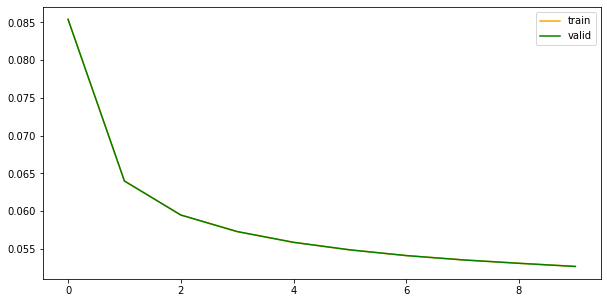

In [ ]:
model.plot_loss()

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-28 15:57:49

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
numpy     : 1.19.5
pandas    : 1.1.5
matplotlib: 3.2.2



---

**END**